In [75]:
import pandas as pd
import numpy as np
import missingno as mo

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rule
from sklearn.linear_model import LogisticRegression as Logit

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

#plotting
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sn

# permutation
from sklearn.inspection import permutation_importance

## Load the Data

In [76]:
jordan = pd.read_csv("arabbaro/arabbaro_jo_labeled_reduced.csv")

In [77]:
jordan.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"],inplace = True)

In [78]:
kuwait = pd.read_csv("arabbaro/arabbaro_kuw_labeled_reduced.csv")

In [79]:
kuwait.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [80]:
egypt = pd.read_csv("arabbaro/arabbaro_egy_labeled_reduced.csv")

In [81]:
egypt.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [82]:
morocco = pd.read_csv("arabbaro/arabbaro_mor_labeled_reduced.csv")

In [83]:
morocco.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [84]:
algeria = pd.read_csv("arabbaro/arabbaro_alg_labeled_reduced.csv")

In [85]:
algeria.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"],inplace = True)

## Functions Containing the Model and Related Metrics

In [86]:
def dempref(df):
    # set up SKLearn Framework
    y = df.y_2_dem_pref_not_in_dem
    if 'y_1_trust_gov' in df.columns:
        X = df.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_trust_gov"])
    else:  
        X = df.drop(columns = "y_2_dem_pref_not_in_dem")

    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

    # Set the folds index to ensure comparable samples
    fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

    # Build the modeling pipeline
    pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

    search_space = [
    
        # NaiveBayes
        {'model': [NB()]},
    
        # KNN with K tuning param
        {'model' : [KNN()],
        'model__n_neighbors':[5,10,25,50]},
    
        # Decision Tree with the Max Depth Param
        {'model': [DT()],
        'model__max_depth':[2,3,4]},
    
        # Random forest with the N Estimators, max depth, and max features tuning param
        {'model' : [RF()],
        'model__max_depth':[6,7,8],
        'model__n_estimators':[500,1000,1500],
        'model__max_features': [5,10,15]},
        
        # logit model
        {'model': [Logit()],
        'model__class_weight':[None, "balanced"]},
    
    ]

    # Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
    search = GridSearchCV(pipe, search_space, 
                         cv = fold_generator,
                         scoring='roc_auc',
                         n_jobs=1)

    # fit the data with the model
    search.fit(train_X,train_y)
    
    best_mod = search.best_estimator_

    return(search.best_score_, search.best_estimator_, search.predict(test_X), m.plot_confusion_matrix(best_mod, test_X, test_y), train_X, test_X, train_y, test_y)

In [87]:
def trustgov(df):
    # set up SKLearn Framework
    y = df.y_1_trust_gov
    if 'y_2_dem_pref_not_in_dem' in df.columns:
        X = df.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_trust_gov"])
    else:  
        X = df.drop(columns = "y_1_trust_gov")
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

    # Set the folds index to ensure comparable samples
    fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

    # Build the modeling pipeline
    pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

    search_space = [
    
        # NaiveBayes
        {'model': [NB()]},
    
        # KNN with K tuning param
        {'model' : [KNN()],
        'model__n_neighbors':[5,10,25,50]},
    
        # Decision Tree with the Max Depth Param
        {'model': [DT()],
        'model__max_depth':[2,3,4]},
    
        # Random forest with the N Estimators, max depth, and max features tuning param
        {'model' : [RF()],
        'model__max_depth':[6,7,8],
        'model__n_estimators':[500,1000,1500],
        'model__max_features': [5,10,15]},
        
        # logit model
        {'model': [Logit()],
        'model__class_weight':[None, "balanced"]},
    
    ]

    # Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
    search = GridSearchCV(pipe, search_space, 
                         cv = fold_generator,
                         scoring='roc_auc',
                         n_jobs=1)

    # fit the data with the model
    search.fit(train_X,train_y)
    
    best_mod = search.best_estimator_

    return(search.best_score_, search.best_estimator_, search.predict(test_X), m.plot_confusion_matrix(best_mod, test_X, test_y), train_X, test_X, train_y, test_y)

## Run the Functions on the Data from Each Country

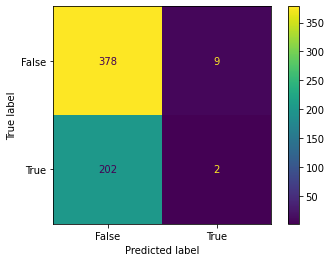

In [88]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(jordan)

In [89]:
score

0.5676611407029569

In [90]:
clf = RF(max_depth=6, max_features=5, n_estimators=500)

In [91]:
clf.fit(train_X,train_y)

RandomForestClassifier(max_depth=6, max_features=5, n_estimators=500)

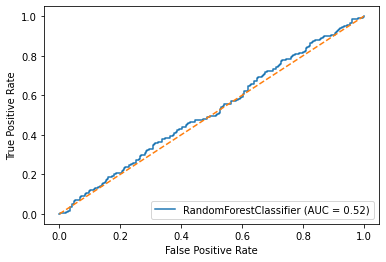

In [92]:
m.plot_roc_curve(clf, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.show()

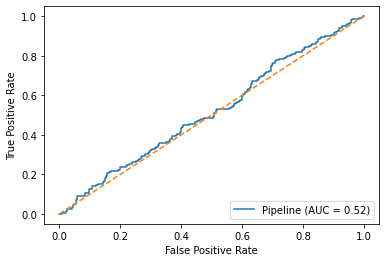

In [93]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [94]:
fig=plt.figure()
fig.show()

<Figure size 432x288 with 0 Axes>

In [95]:
print("hello world")

hello world


In [96]:
# Set the the first threshold as 0.8
threshold1 = 0.8

In [97]:
# Set the the first threshold as 0.8
threshold2 = 0.2

In [98]:
# use predict probabilities function
# First predictive threshold: 1 when greater than 80% probability
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [99]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

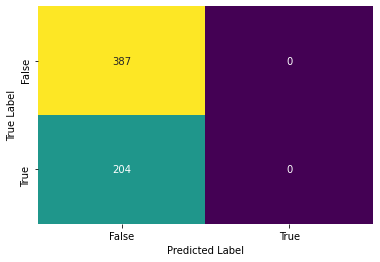

In [100]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [101]:
# Second predictive threshold: 0 when greater than 20% probability
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [102]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

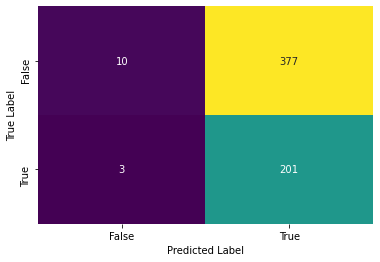

In [103]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

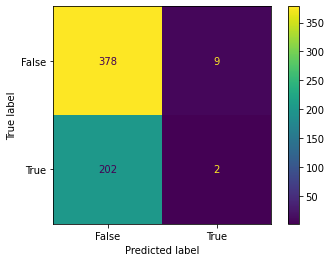

In [104]:
confusion.figure_

In [105]:
# show which model worked best
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1500))])

In [106]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [107]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.030361,0.001868,0.026625,0.034098
1,male,0.013995,0.001727,0.010542,0.017449
2,income,0.013770,0.001267,0.011236,0.016304
3,educ,0.013093,0.002296,0.008500,0.017686
4,internet_use_bin,0.012190,0.001697,0.008796,0.015583
5,housewife,0.011512,0.000845,0.009823,0.013202
6,unemp,0.009594,0.000618,0.008357,0.010830
7,neighb_rich,0.008804,0.001580,0.005643,0.011964
8,infs_socmed,0.008239,0.001697,0.004846,0.011633
9,infs_television,0.008239,0.000765,0.006708,0.009770


In [108]:
vi_dat.to_csv("variable importance csv/jordan_y2")

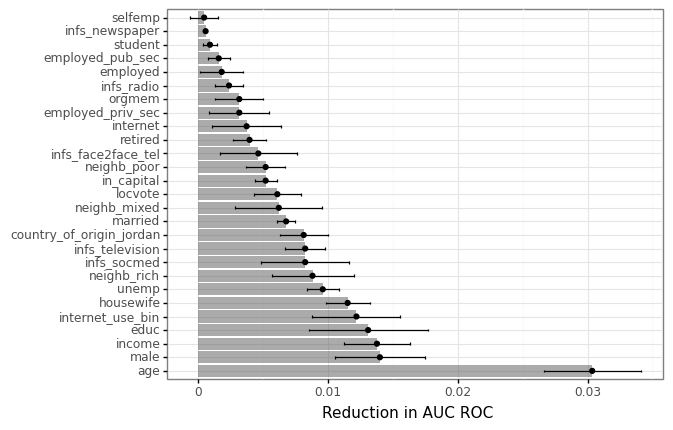

<ggplot: (8795515401117)>

In [109]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

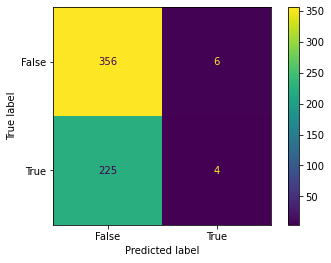

In [110]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(jordan)

In [111]:
score

0.571938905401162

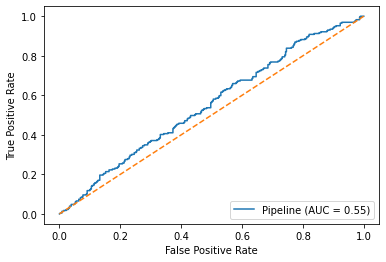

In [112]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

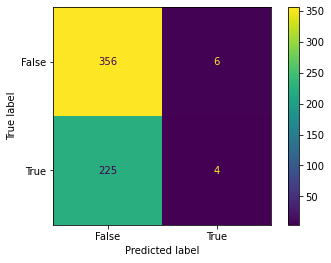

In [113]:
confusion.figure_

In [114]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [115]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

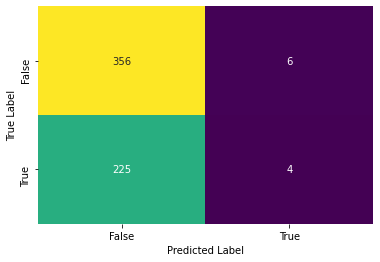

In [116]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [117]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [118]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

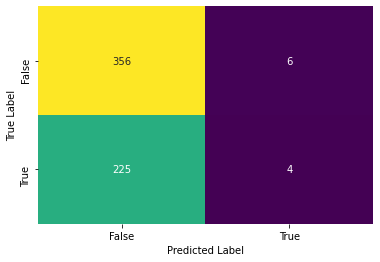

In [119]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [120]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()), ('model', GaussianNB())])

In [121]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [122]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,infs_radio,0.004289,0.003719,-0.003150,0.011728
1,infs_newspaper,0.001693,0.002473,-0.003253,0.006639
2,age,0.000339,0.001106,-0.001873,0.002550
3,income,0.000000,0.000000,0.000000,0.000000
4,educ,0.000000,0.000000,0.000000,0.000000
5,infs_socmed,0.000000,0.000000,0.000000,0.000000
6,infs_television,0.000000,0.000000,0.000000,0.000000
7,infs_face2face_tel,0.000000,0.000000,0.000000,0.000000
8,internet_use_bin,0.000000,0.000000,0.000000,0.000000
9,internet,0.000000,0.000000,0.000000,0.000000


In [123]:
vi_dat.to_csv("variable importance csv/jordan_y1")

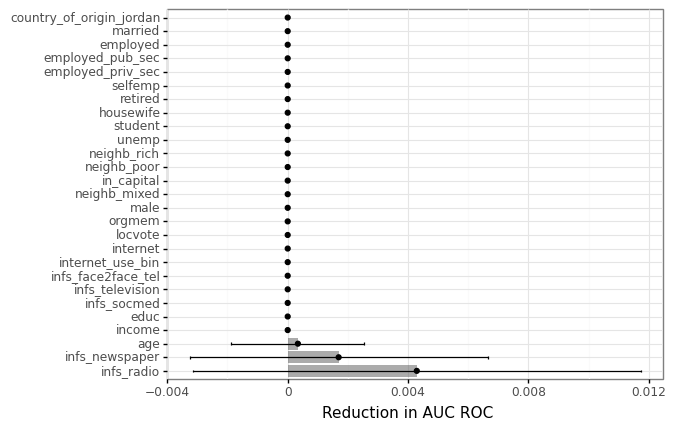

<ggplot: (8795497932846)>

In [124]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [125]:
kuwait.isna().sum()

below_medinc             0
above_medinc             0
in_capital               0
married                  0
employed                 0
employed_pub_sec         0
employed_priv_sec        0
selfemp                  0
retired                  0
housewife                0
student                  0
unemp                    0
neighb_rich           1304
neighb_poor           1304
neighb_mixed          1304
educ                     0
male                     0
age                      0
orgmem                   0
charity                  0
campaign_attend          0
locvote                  0
internet                 0
internet_use_bin         0
infs_face2face_tel       0
infs_newspaper           0
infs_radio               0
infs_television          0
infs_socmed              0
y_1_trust_gov            0
dtype: int64

In [126]:
kuwait.drop(columns = ["neighb_rich", "neighb_poor", "neighb_mixed"], inplace = True)

In [127]:
kuwait

,below_medinc,above_medinc,in_capital,married,employed,employed_pub_sec,employed_priv_sec,selfemp,retired,housewife,...,campaign_attend,locvote,internet,internet_use_bin,infs_face2face_tel,infs_newspaper,infs_radio,infs_television,infs_socmed,y_1_trust_gov
0,False,False,False,True,True,True,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False
1,False,True,False,True,True,True,False,False,False,False,...,True,True,True,1.0,False,False,False,False,True,True
2,False,False,False,True,False,False,False,False,True,False,...,False,False,True,0.8,False,False,False,False,True,False
3,True,False,False,True,False,False,False,False,True,False,...,True,True,True,1.0,False,False,False,False,True,False
4,True,False,False,True,True,True,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,False,False,False,False,False,False,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,True
1300,False,True,False,True,True,False,True,False,False,False,...,False,False,True,1.0,False,False,False,False,True,True
1301,False,False,False,True,True,False,True,False,False,False,...,False,False,True,1.0,False,False,False,False,True,True
1302,False,False,False,False,False,False,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,True


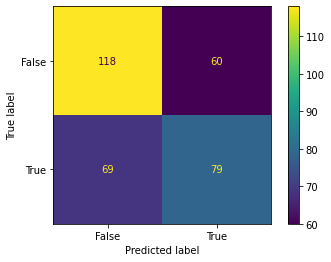

In [128]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(kuwait)

In [129]:
score

0.6424017368220756

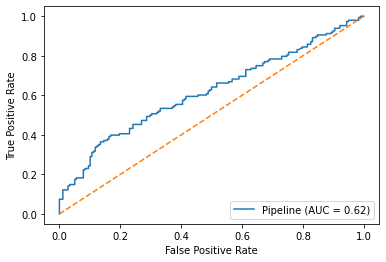

In [130]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

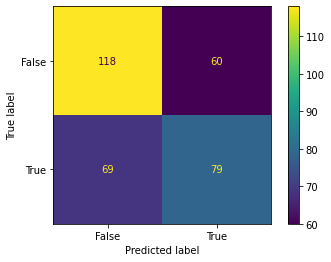

In [131]:
confusion.figure_

In [132]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model', LogisticRegression())])

In [133]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [134]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

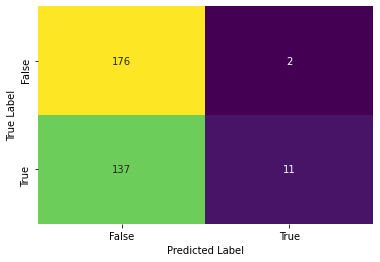

In [135]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [136]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [137]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

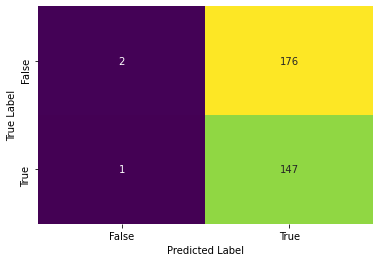

In [138]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [139]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [140]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,infs_socmed,6.278119e-02,0.013120,0.036541,0.089021
1,employed,3.047035e-02,0.011039,0.008392,0.052549
2,locvote,1.840491e-02,0.009679,-0.000952,0.037762
3,retired,1.820041e-02,0.006046,0.006109,0.030292
4,employed_pub_sec,1.738241e-02,0.006066,0.005250,0.029515
5,internet_use_bin,8.793456e-03,0.003458,0.001877,0.015710
6,educ,7.975460e-03,0.002183,0.003609,0.012342
7,student,7.770961e-03,0.002105,0.003560,0.011982
8,campaign_attend,6.134969e-03,0.005820,-0.005505,0.017775
9,age,5.930470e-03,0.004161,-0.002391,0.014252


In [141]:
vi_dat.to_csv("variable importance csv/kuwait_y1")

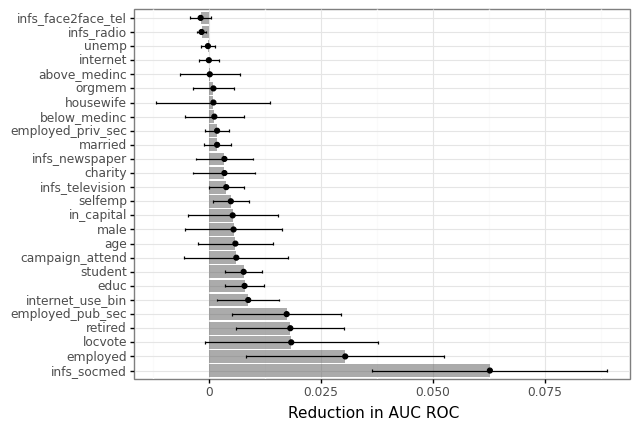

<ggplot: (8795485384060)>

In [142]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

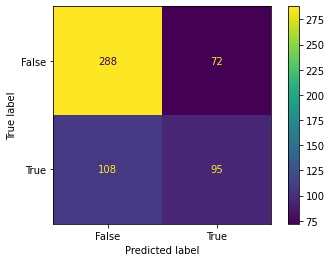

In [143]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(morocco)

In [144]:
score

0.7201808384047954

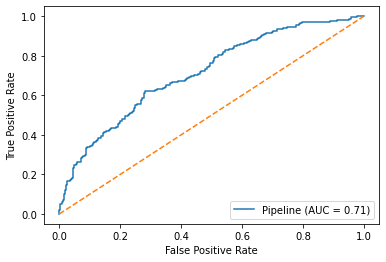

In [145]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

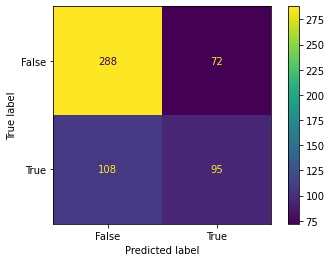

In [146]:
confusion.figure_

In [147]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1500))])

In [148]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [149]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

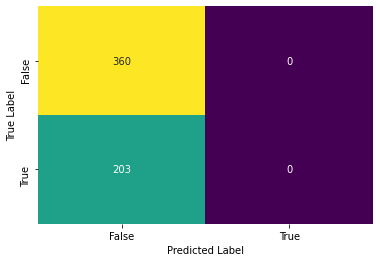

In [150]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [151]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [152]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

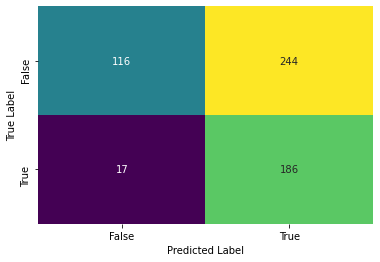

In [153]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [154]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [155]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,educ,0.040925,0.004833,0.031259,0.050591
1,internet_use_bin,0.029656,0.005265,0.019126,0.040186
2,age,0.023606,0.007249,0.009109,0.038104
3,internet,0.020878,0.005840,0.009197,0.032559
4,male,0.017675,0.002663,0.012349,0.023001
5,orgmem,0.010676,0.001678,0.007321,0.014031
6,infs_socmed,0.010320,0.003818,0.002684,0.017957
7,protest,0.010083,0.003138,0.003806,0.016360
8,petit,0.009727,0.003152,0.003423,0.016031
9,housewife,0.009727,0.001861,0.006006,0.013448


In [156]:
vi_dat.to_csv("variable importance csv/morocco_y2")

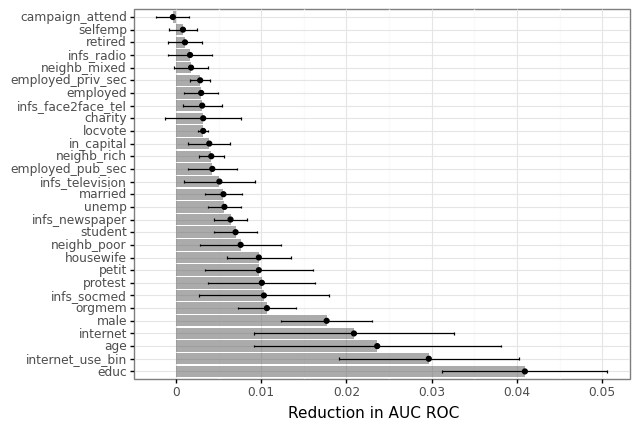

<ggplot: (8795485444009)>

In [157]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

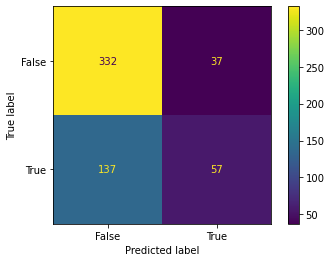

In [158]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(morocco)

In [159]:
score

0.7434610355019006

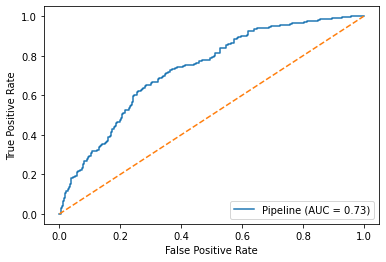

In [160]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

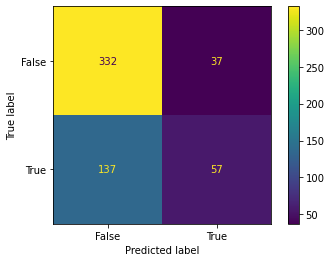

In [161]:
confusion.figure_

In [162]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=7, max_features=5,
                                        n_estimators=1500))])

In [163]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [164]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

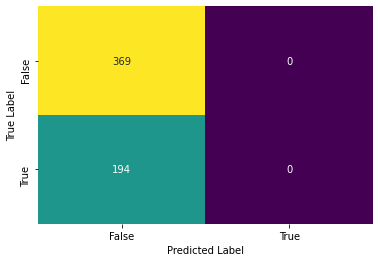

In [165]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [166]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [167]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

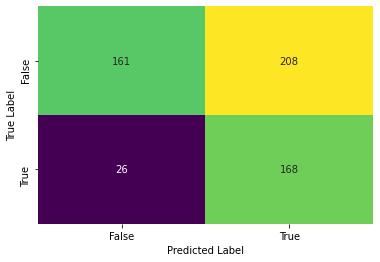

In [168]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [169]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [170]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.066785,0.002300,0.062185,0.071386
1,locvote,0.057058,0.002939,0.051179,0.062937
2,educ,0.020047,0.002715,0.014617,0.025478
3,protest,0.017912,0.001927,0.014057,0.021767
4,infs_television,0.015896,0.002689,0.010517,0.021274
5,charity,0.015658,0.002615,0.010428,0.020889
6,campaign_attend,0.015540,0.003010,0.009519,0.021560
7,internet_use_bin,0.013049,0.001061,0.010927,0.015171
8,infs_socmed,0.011625,0.002419,0.006786,0.016464
9,married,0.011507,0.001383,0.008740,0.014273


In [171]:
vi_dat.to_csv("variable importance csv/morocco_y1")

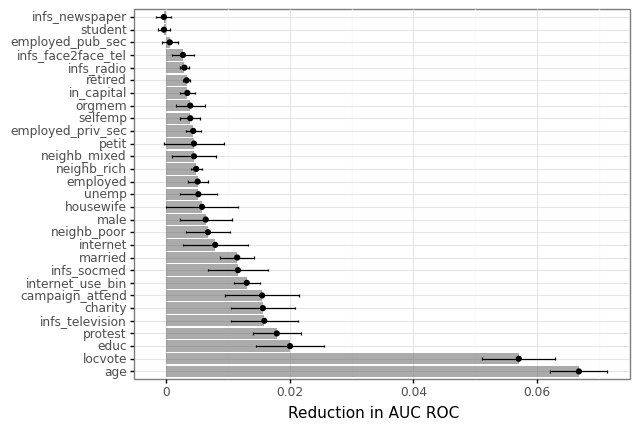

<ggplot: (8795485384891)>

In [172]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [173]:
egypt.drop(columns = "locvote", inplace = True)

In [174]:
egypt.dropna(inplace = True)

In [175]:
egypt.isna().sum()

income                     0
in_capital                 0
married                    0
employed                   0
employed_pub_sec           0
employed_priv_sec          0
selfemp                    0
retired                    0
housewife                  0
student                    0
unemp                      0
neighb_rich                0
neighb_poor                0
neighb_mixed               0
educ                       0
male                       0
age                        0
orgmem                     0
charity                    0
petit                      0
protest                    0
campaign_attend            0
internet                   0
internet_use_bin           0
infs_face2face_tel         0
infs_newspaper             0
infs_radio                 0
infs_television            0
infs_socmed                0
y_2_dem_pref_not_in_dem    0
y_1_trust_gov              0
dtype: int64

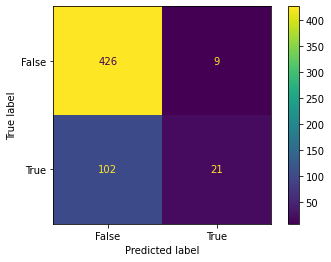

In [176]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(egypt)

In [177]:
score

0.749936850739154

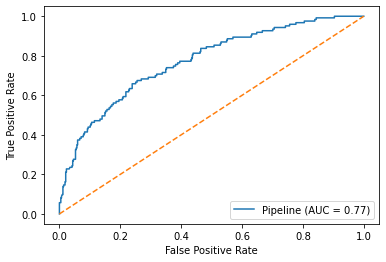

In [178]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

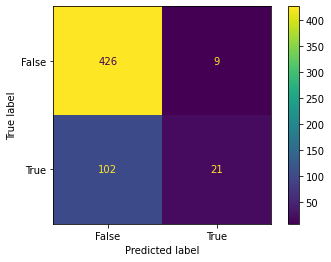

In [179]:
confusion.figure_

In [180]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=7, max_features=5,
                                        n_estimators=1000))])

In [181]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [182]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

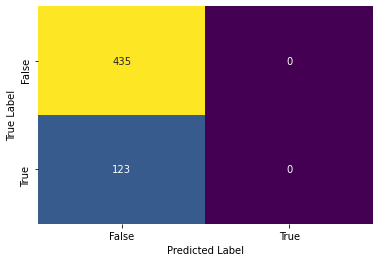

In [183]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [184]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [185]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

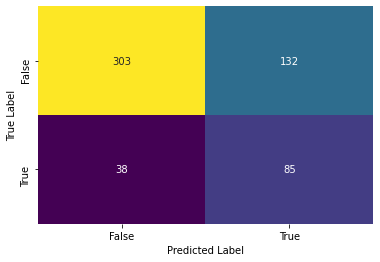

In [186]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [187]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [188]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,protest,0.026778,0.003057,0.020664,0.032893
1,infs_socmed,0.024866,0.000717,0.023431,0.026300
2,internet_use_bin,0.020921,0.001604,0.017713,0.024128
3,age,0.008607,0.002689,0.003229,0.013986
4,petit,0.006097,0.001942,0.002212,0.009982
5,educ,0.005858,0.001435,0.002989,0.008727
6,income,0.005858,0.001331,0.003195,0.008520
7,campaign_attend,0.004901,0.000586,0.003730,0.006073
8,orgmem,0.003706,0.000878,0.001949,0.005463
9,infs_television,0.002869,0.001484,-0.000098,0.005836


In [189]:
vi_dat.to_csv("variable importance csv/egypt_y2")

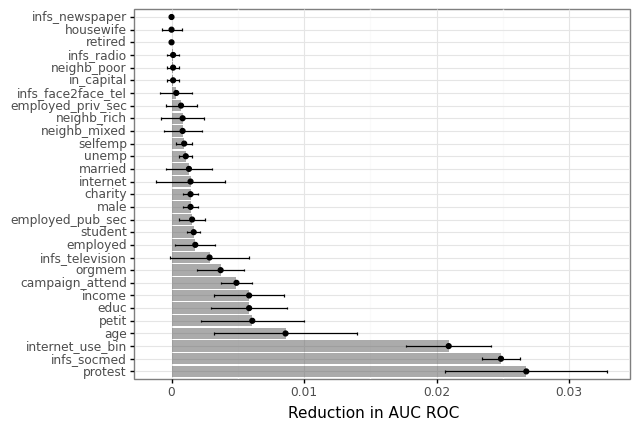

<ggplot: (8795486047016)>

In [190]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

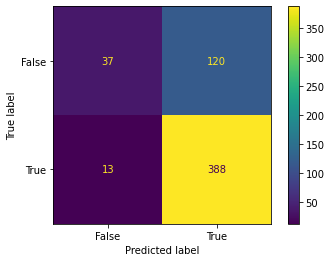

In [191]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(egypt)

In [192]:
score

0.7211288467954624

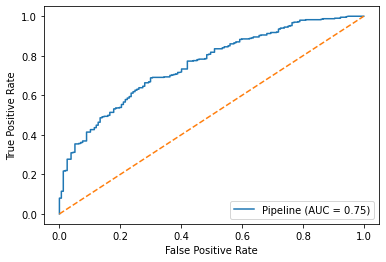

In [193]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

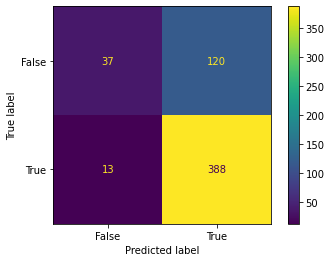

In [194]:
confusion.figure_

In [195]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=7, max_features=10,
                                        n_estimators=500))])

In [196]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [197]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

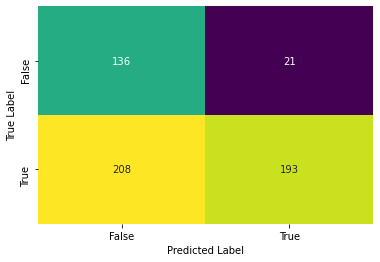

In [198]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [199]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [200]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

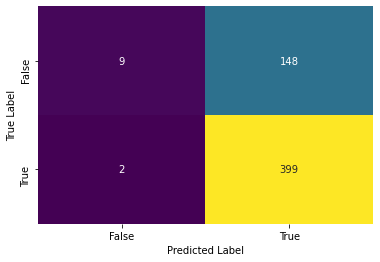

In [201]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [202]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [203]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,protest,0.044232,0.002300,0.039633,0.048831
1,age,0.025224,0.001577,0.022070,0.028378
2,unemp,0.024746,0.002689,0.019368,0.030124
3,charity,0.021996,0.003692,0.014612,0.029381
4,income,0.021279,0.002869,0.015541,0.027017
5,infs_television,0.019605,0.000956,0.017693,0.021518
6,internet_use_bin,0.010400,0.002191,0.006018,0.014783
7,infs_socmed,0.010161,0.001000,0.008161,0.012162
8,campaign_attend,0.008727,0.000717,0.007292,0.010161
9,educ,0.006814,0.001394,0.004026,0.009602


In [204]:
vi_dat.to_csv("variable importance csv/egypt_y1")

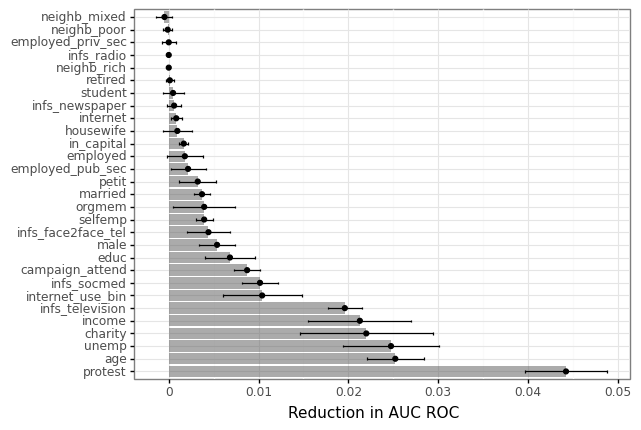

<ggplot: (8795532791757)>

In [205]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [206]:
algeria.dropna(inplace = True)

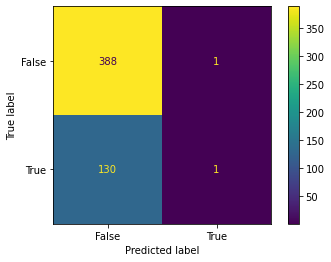

In [207]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(algeria)

In [208]:
score

0.611625511220465

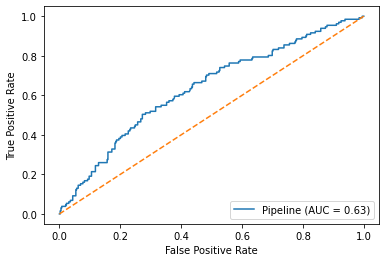

In [209]:
m.plot_roc_curve(best_mod,test_X,test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

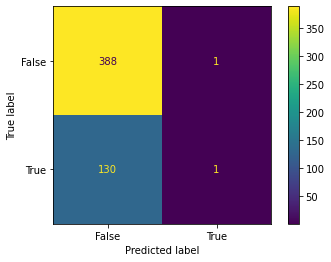

In [210]:
confusion.figure_

In [211]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1000))])

In [212]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [213]:
confusion_matrix_1 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold1))

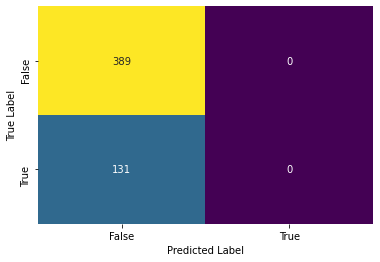

In [214]:
sn.heatmap(confusion_matrix_1, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [215]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [216]:
confusion_matrix_2 = pd.DataFrame(m.confusion_matrix(test_y, pred_threshold2))

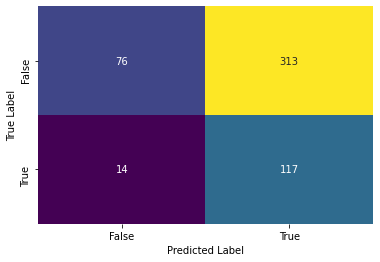

In [217]:
sn.heatmap(confusion_matrix_2, 
    annot=True, 
    fmt="d", 
    xticklabels =["False", "True"], 
    yticklabels = ["False", "True"], 
    cbar = False,
    cmap= "viridis")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [218]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [219]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.004624,0.000481,0.003663,0.005586
1,campaign_attend,0.004496,0.001149,0.002198,0.006794
2,educ,0.004239,0.001191,0.001856,0.006621
3,internet_use_bin,0.003725,0.000944,0.001837,0.005613
4,locvote,0.003340,0.000481,0.002379,0.004301
5,married,0.002826,0.001044,0.000739,0.004913
6,orgmem,0.002312,0.000771,0.000771,0.003854
7,neighb_mixed,0.002184,0.000514,0.001156,0.003211
8,retired,0.002055,0.000257,0.001541,0.002569
9,neighb_poor,0.001670,0.000514,0.000642,0.002697


In [220]:
vi_dat.to_csv("variable importance csv/algeria_y2")

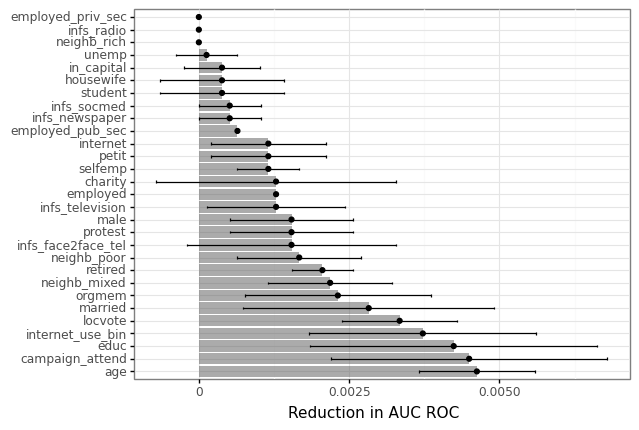

<ggplot: (8795485397318)>

In [221]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

## Logit Models

In [222]:
# train-test split
y = jordan.y_2_dem_pref_not_in_dem
X = jordan.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_trust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [223]:
LogitR = Logit(class_weight = 'balanced')

In [224]:
clf = LogitR.fit(train_X, train_y)

In [225]:
pred_y= clf.predict(test_X)

In [226]:
m.roc_auc_score(test_y, pred_y)

0.4907470740234078

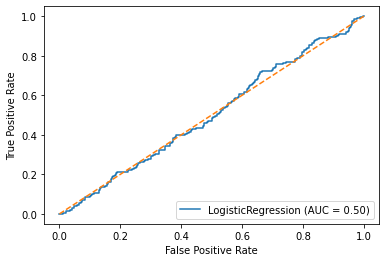

In [227]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [228]:
# train-test split
y = jordan.y_1_trust_gov
X = jordan.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_trust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [229]:
clf = LogitR.fit(train_X, train_y)

In [230]:
pred_y= clf.predict(test_X)

In [231]:
m.roc_auc_score(test_y, pred_y)

0.5285833192598133

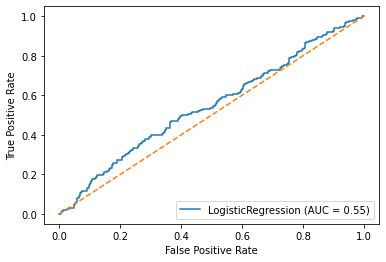

In [232]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [233]:
# train-test split
y = kuwait.y_1_trust_gov
X = kuwait.drop(columns = ["y_1_trust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [234]:
clf = LogitR.fit(train_X, train_y)

In [235]:
pred_y= clf.predict(test_X)

In [236]:
m.roc_auc_score(test_y, pred_y)

0.5

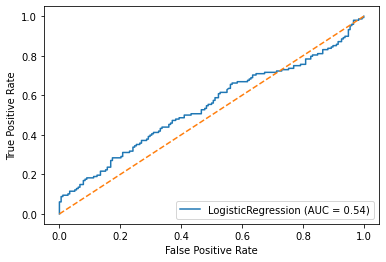

In [237]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [238]:
# train-test split
y = morocco.y_2_dem_pref_not_in_dem
X = morocco.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_trust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [239]:
clf = LogitR.fit(train_X, train_y)

In [240]:
pred_y= clf.predict(test_X)

In [241]:
m.roc_auc_score(test_y, pred_y)

0.6481800766283524

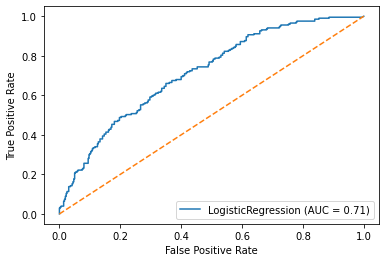

In [242]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [243]:
# train-test split
y = morocco.y_1_trust_gov
X = morocco.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_trust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [244]:
clf = LogitR.fit(train_X, train_y)

In [245]:
pred_y= clf.predict(test_X)

In [246]:
m.roc_auc_score(test_y, pred_y)

0.6588997848741375

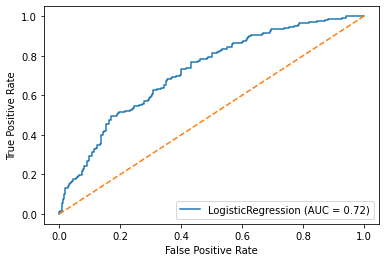

In [247]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [248]:
# train-test split
y = egypt.y_2_dem_pref_not_in_dem
X = egypt.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_trust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [249]:
clf = LogitR.fit(train_X, train_y)

In [250]:
pred_y= clf.predict(test_X)

In [251]:
m.roc_auc_score(test_y, pred_y)

0.6913372582001682

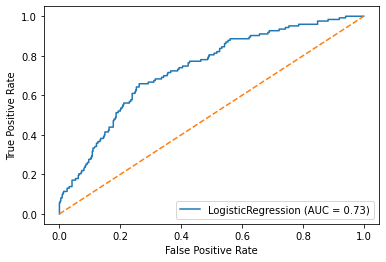

In [252]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [253]:
# train-test split
y = egypt.y_1_trust_gov
X = egypt.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_trust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [254]:
clf = LogitR.fit(train_X, train_y)

In [255]:
pred_y= clf.predict(test_X)

In [256]:
m.roc_auc_score(test_y, pred_y)

0.6644138062487095

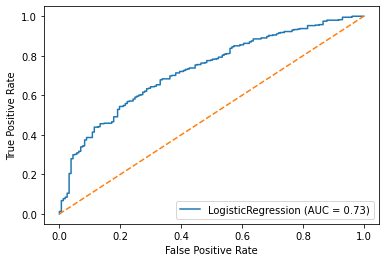

In [257]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

In [258]:
# train-test split
y = algeria.y_2_dem_pref_not_in_dem
X = algeria.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_trust_gov"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

In [259]:
clf = LogitR.fit(train_X, train_y)

In [260]:
pred_y= clf.predict(test_X)

In [261]:
m.roc_auc_score(test_y, pred_y)

0.6240310838124766

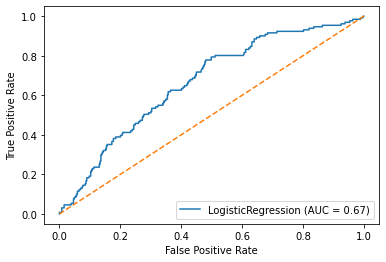

In [262]:
m.plot_roc_curve(LogitR, test_X, test_y)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')